In [30]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import optuna
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from datetime import datetime


In [31]:

class RewardLoggingCallback(BaseCallback):
    """
    Custom callback for logging episode rewards during training.

    This callback tracks rewards for each episode during training. It accumulates rewards
    step-by-step and logs the total reward at the end of each episode. The rewards for all
    completed episodes are stored in a list for analysis or visualization after training.

    Attributes:
        episode_rewards (list): A list of total rewards for all completed episodes.
        current_episode_reward (float): The cumulative reward for the current episode.
    """

    def __init__(self):
        """
        Initializes the RewardLoggingCallback.

        Sets up the storage for episode rewards and initializes the current episode reward tracker.
        """
        super(RewardLoggingCallback, self).__init__()
        self.episode_rewards = []  # List to store rewards for completed episodes
        self.current_episode_reward = 0  # Accumulates rewards for the current episode

    def _on_step(self) -> bool:
        """
        Called after each environment step during training.

        Accumulates the reward for the current step into the current episode reward.
        If the episode ends, logs the total episode reward and resets the tracker.

        Returns:
            bool: Always returns True, allowing training to continue.
        """
        # Accumulate reward for the current step
        self.current_episode_reward += self.locals["rewards"][0]

        # Check if the episode is done
        if self.locals["dones"][0]:
            # Log the total reward for the completed episode
            self.episode_rewards.append(self.current_episode_reward)
            # Reset the tracker for the next episode
            self.current_episode_reward = 0

        return True

In [32]:
def optimize_ppo(trial):
    """
    Optimize PPO hyperparameters using Optuna.
    """
    # Set up the environment (CartPole-v1)
    env = gym.make("CartPole-v1", render_mode="rgb_array")  # Set render_mode to rgb_array

    # Wrap the environment in a DummyVecEnv for compatibility with PPO
    env = DummyVecEnv([lambda: env])

    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.99)
    n_epochs = trial.suggest_int("n_epochs", 3, 10)
    ent_coef = trial.suggest_float("ent_coef", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 512, step=32)
    n_steps = trial.suggest_int("n_steps", 64, 2048, step=64)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 0.99)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)

    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=lr,
        gamma=gamma,
        n_epochs=n_epochs,
        ent_coef=ent_coef,
        batch_size=batch_size,
        n_steps=n_steps,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        verbose=0,
    )
    model.learn(total_timesteps=100000)


    # Evaluate the agent's performance
    total_rewards = []
    for _ in range(100):
        state = env.reset()  # No unpacking needed
        total_reward = 0
        done = False
        while not done:
            action, _ = model.predict(state, deterministic=True)
            state, reward, done, info = env.step(action)  # Unpack four values instead of five
            total_reward += reward
        total_rewards.append(total_reward)

    # Return the mean of total rewards as the optimization objective
    return np.mean(total_rewards)

In [33]:
def plot_learning_curve(rewards):
    """
    Plot the learning curve using the logged rewards from training.

    Args:
        rewards (list): List of total rewards per episode.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(rewards)), rewards, label="Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Learning Curve for CartPole-v1 (SB3)")
    plt.legend()
    plt.grid()
    plt.show()


In [34]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=100)
best_params = study.best_params


[I 2024-12-10 18:54:14,677] A new study created in memory with name: no-name-07bb9e56-1a15-4a4b-af69-eac136ddb298
[I 2024-12-10 18:55:34,794] Trial 0 finished with value: 384.92999267578125 and parameters: {'learning_rate': 7.741787043120261e-05, 'gamma': 0.9730210874257019, 'n_epochs': 10, 'ent_coef': 0.0009636082442541067, 'batch_size': 128, 'n_steps': 640, 'gae_lambda': 0.9296212459042291, 'clip_range': 0.19696844612229897}. Best is trial 0 with value: 384.92999267578125.
[I 2024-12-10 18:56:29,133] Trial 1 finished with value: 415.79998779296875 and parameters: {'learning_rate': 0.00010083239015662252, 'gamma': 0.9423891065943031, 'n_epochs': 3, 'ent_coef': 0.0025300712823787433, 'batch_size': 320, 'n_steps': 960, 'gae_lambda': 0.9809839005955184, 'clip_range': 0.16521750074758657}. Best is trial 1 with value: 415.79998779296875.
/Users/xuenbei/miniconda3/lib/python3.12/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 224, but bec

In [35]:


from gymnasium.wrappers import RecordVideo

def train_and_render_cartpole(best_params):
    """
    Train a PPO agent with optimized hyperparameters on CartPole-v1
    and render it using a video recorder.
    """

    # Create the environment with render_mode set to 'rgb_array'
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    # Train the agent with best hyperparameters
    final_model = PPO(
        "MlpPolicy",
        env,
        learning_rate=best_params["learning_rate"],
        gamma=best_params["gamma"],
        n_epochs=best_params["n_epochs"],
        ent_coef=best_params["ent_coef"],
        batch_size=best_params["batch_size"],
        n_steps=best_params["n_steps"],
        gae_lambda=best_params["gae_lambda"],
        clip_range=best_params["clip_range"],
        verbose=1,
    )
    callback = RewardLoggingCallback()
    final_model.learn(total_timesteps=100000, callback=callback)

    # Plot the learning curve
    plot_learning_curve(callback.episode_rewards)

    # Create the environment
    eval_env = gym.make("CartPole-v1", render_mode="rgb_array")

    # Specify the directory and custom name prefix
    video_folder = "/Users/xuenbei/Desktop/rl_coursework2_02015483/sb3/cartpole_env/videos"
    video_name_prefix = f"cartpole_run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    # Wrap the environment with RecordVideo
    eval_env = RecordVideo(
        eval_env,
        video_folder=video_folder,
        episode_trigger=lambda e: True,  # Record all episodes
        name_prefix=video_name_prefix  # Custom name prefix for the videos
    )

    # Evaluation loop
    state, _ = eval_env.reset()
    done = False

    while not done:
        # Predict action
        action, _ = final_model.predict(state, deterministic=True)
        state, reward, done, truncated, _ = eval_env.step(action)
        done = done or truncated

    eval_env.close()

    # Evaluation loop
    state, _ = eval_env.reset()
    done = False
    state_trajectory = []

    while not done:
        state_trajectory.append(state)  # Record the state
        action, _ = final_model.predict(state, deterministic=True)
        state, reward, done, truncated, _ = eval_env.step(action)
        done = done or truncated

    eval_env.close()

    # Plotting Pole Angles
    pole_angles = [s[2] for s in state_trajectory]
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(pole_angles)), pole_angles, label='Pole Angle', color='b')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label="Vertical Position")
    plt.xlabel('Time Step')
    plt.ylabel('Pole Angle (radians)')
    plt.title('Pole Angle Over Time During Evaluation (SB3)')
    plt.legend()
    plt.grid()
    plt.show()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.1     |
|    ep_rew_mean     | 22.1     |
| time/              |          |
|    fps             | 1830     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1280     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 23.4         |
|    ep_rew_mean          | 23.4         |
| time/                   |              |
|    fps                  | 756          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0059731468 |
|    clip_fraction        | 0.0288       |
|    clip_range           | 0.189        |
|    en

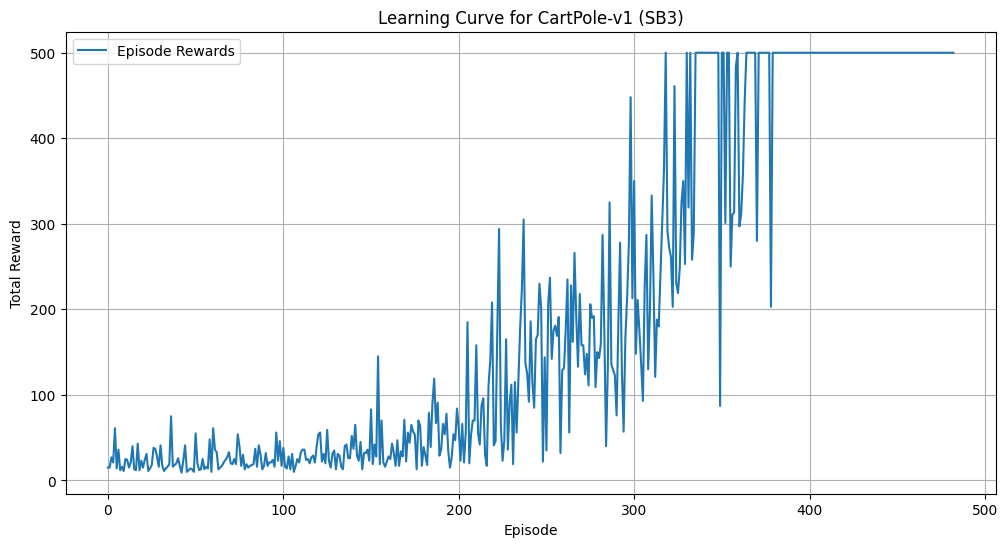

/Users/xuenbei/miniconda3/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/xuenbei/Desktop/rl_coursework2_02015483/sb3/cartpole_env/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


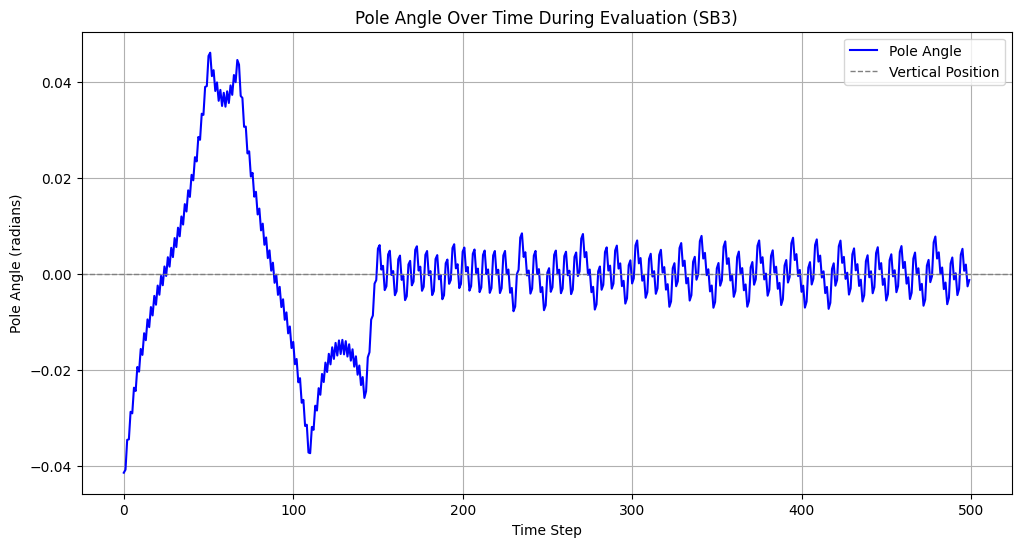

In [37]:
train_and_render_cartpole(best_params)


In [39]:

optuna.visualization.plot_param_importances(study).show()
